# Определение возраста покупателей

## Исследовательский анализ данных

Импорт необходимых библиотек

In [14]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import numpy as np

Загружаем данные

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Сводная информация по таблице

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [9]:
labels.duplicated().sum()

0

Предобработка не требуется, данные в норме. Посмотрим на распределение данных по возрасту

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение данных по возрасту')

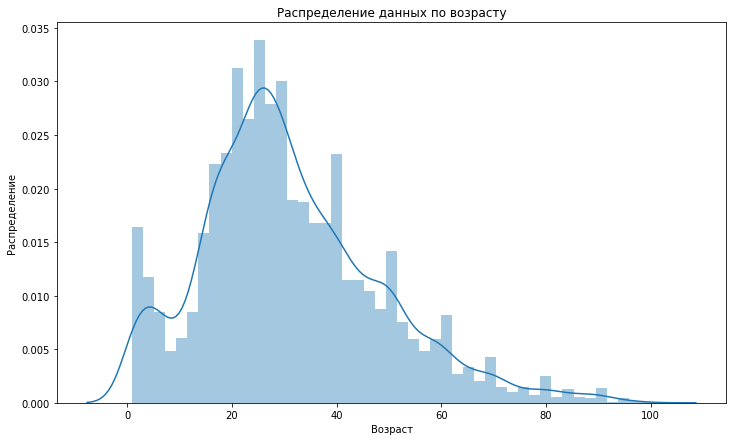

In [46]:
plt.figure(figsize=(12, 7))
p = sns.distplot(labels["real_age"])
p.set_xlabel('Возраст')
p.set_ylabel('Распределение')
p.set_title('Распределение данных по возрасту')

Text(0.5, 1.0, 'Распределение данных по возрасту')

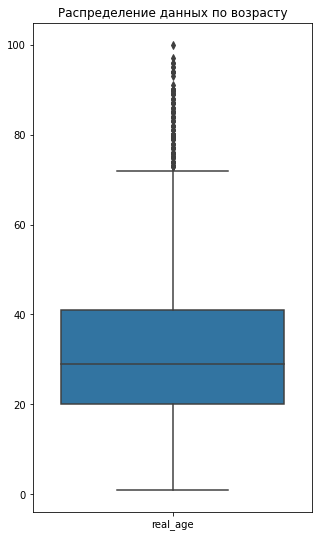

In [53]:
plt.figure(figsize=(5, 9))
p = sns.boxplot(data=labels)
p.set_title('Распределение данных по возрасту')

In [ ]:
features, target = next(train_gen_flow)

In [ ]:
features.shape

Напечатаем 15 фотографий

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


Присутствуют повернутые фотографии, черное белые, обрезанные и разным фоном.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    optimizer = Adam(lr=0.00025)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-03-16 11:46:35.455078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-16 11:46:35.746116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 259.1293 - mae: 11.6699 - val_loss: 667.8841 - val_mae: 20.7602
Epoch 2/10
178/178 - 37s - loss: 79.7603 - mae: 6.7593 - val_loss: 389.5133 - val_mae: 14.7935
Epoch 3/10
178/178 - 37s - loss: 43.7180 - mae: 5.0420 - val_loss: 394.7394 - val_mae: 14.4590
Epoch 4/10
178/178 - 37s - loss: 27.9002 - mae: 4.0386 - val_loss: 155.4213 - val_mae: 9.8708
Epoch 5/10
178/178 - 37s - loss: 21.5672 - mae: 3.5816 - val_loss: 86.7246 - val_mae: 7.0341
Epoch 6/10
178/178 - 37s - loss: 16.7809 - mae: 3.1581 - val_loss: 76.7245 - val_mae: 6.6240
Epoch 7/10
178/178 - 38s - loss: 12.7600 - mae: 2.7552 - val_loss: 68.8727 - val_mae: 6.2792
Epoch 8/10
178/178 - 37s - loss: 11.3921 - mae: 2.5744 - val_loss: 69.1928 - val_mae: 6.2821
Epoch 9/10
178/178 - 37s - loss: 10.2471 - mae: 2.4529 - val_loss: 73.1429 - val_mae: 6.4139
Epoch 10/10
178/178 - 37s - loss: 9.6149 - mae: 2.3384 - val_loss: 72.0021 - val_mae: 6.5102

60/60 - 9s - loss: 72.0021 - mae: 6.5102
Test MAE: 6.5102

```

## Анализ обученной модели

Модель на тестовых данных показала MAE: 6.5102

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы